# Araba Fiyatları (Car Prices)

🎯 Bu challenge’ın amacı, bir dataset hazırlamak ve şimdiye kadar öğrendiğiniz bazı feature selection tekniklerini uygulamaktır.

🚗 Arabalarla ilgili bir veri setiyle çalışıyoruz ve bir arabanın pahalı mı yoksa ucuz mu olduğunu tahmin etmek istiyoruz.

In [27]:
# Data manipulation
import numpy as np
import pandas as pd
# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Sayısal bir özelliğin normal dağılım gösterip göstermediğini kontrol etme
from statsmodels.graphics.gofplots import qqplot


In [28]:
url = "https://d32aokrjazspmn.cloudfront.net/materials/ML_Cars_dataset.csv"

❓ CSV dosyasını `df` adlı bir veri çerçevesine yükleyin.

In [33]:
df = pd.read_csv(url)
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,64.1,2548,dohc,four,2.68,5000,expensive
1,std,front,64.1,2548,dohc,four,2.68,5000,expensive
2,std,front,65.5,2823,ohcv,six,3.47,5000,expensive
3,std,front,NaN,2337,ohc,four,3.40,5500,expensive
4,std,front,66.4,2824,ohc,five,3.40,5500,expensive


ℹ️ Dataset’in açıklaması [burada](https://drive.google.com/file/d/1ADSyjWfRGYqdXwCCN4PPC7PjQeMZ-ap-/view?usp=sharing ) mevcuttur. Egzersiz boyunca buna mutlaka referans verin.

## (1) Yinelenenler (Duplicates)

❓ Varsa, veri kümesinden yinelenenleri kaldırın. ❓

*Veri çerçevesini `df`* üzerine yazın.

In [36]:
# Önce kaç tane yinelenen satır olduğunu görelim
duplicate_count = df.duplicated().sum()
print(f"Silinmeden önceki yinelenen satır sayısı: {duplicate_count}")

# Yinelenenleri kaldırıp df üzerine yazıyoruz
df = df.drop_duplicates()

# İşlem sonrası boyut kontrolü
print(f"Temizlik sonrası veri seti boyutu: {df.shape}")

Silinmeden önceki yinelenen satır sayısı: 0
Temizlik sonrası veri seti boyutu: (191, 9)


## (2)  Eksik değerler (Missing values)

❓ Eksik değerleri bulun ve bunları ya `strategy = "most frequent"` (kategorik değişkenler için) ya da `strategy = "median"` (sayısal değişkenler için) kullanarak doldurun ❓

In [37]:
from sklearn.impute import SimpleImputer

# 1. Sayısal ve Kategorik sütunları ayırt ediyoruz
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# 2. Sayısal veriler için Imputer (Strateji: Median)
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# 3. Kategorik veriler için Imputer (Strateji: Most Frequent)
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Kontrol: Hala eksik değer var mı? (0 çıkmalı)
print(f"Kalan eksik değer sayısı: {df.isnull().sum().sum()}")

Kalan eksik değer sayısı: 0


### `carwidth`

<details>
    <summary> 💡 <i>İpucu</i> </summary>
    <br>
    ℹ️ <code>carwidth</code> sütununda eksik değerler birden fazla şekilde temsil edilmektedir. Bazıları <code>np.nan</code>, bazıları ise <code>*</code> olarak yer alır. Bunlar tespit edildikten sonra, eksik değerler verinin %30’undan daha azını oluşturduğu için medyan değerle doldurulabilir.
</details>

In [38]:
# 2. 'carwidth' Sütunundaki '*' Karakterini Temizleme
# '*' karakterini NaN ile değiştiriyoruz
df['carwidth'] = df['carwidth'].replace('*', np.nan)

# Sütunu sayısal tipe zorluyoruz (Object -> Float)
df['carwidth'] = pd.to_numeric(df['carwidth'])

# 3. Eksik Değerleri Doldurma (Artık carwidth sayısal olduğu için median kullanabiliriz)
# Sayısal ve Kategorik sütunları ayır
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# Sayısal Değişkenler -> Median
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Kategorik Değişkenler -> En Sık Görülen (Most Frequent)
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# carwidth sütununun düzgün dolup dolmadığını kontrol edelim
print(f"carwidth eksik değer sayısı: {pd.isna(df['carwidth']).sum()}")
print(df['carwidth'].head())

carwidth eksik değer sayısı: 0
0    64.1
2    65.5
3    66.5
4    66.4
5    66.3
Name: carwidth, dtype: float64


### `enginelocation`

<details>
    <summary>💡 <i>İpucu</i> </summary>
    <br>
    ℹ️ <code>enginelocation</code> kategorik bir feature olduğundan ve kategorilerin büyük çoğunluğu <code>front</code> olduğu için, en sık görülen değerle doldurun.
</details>

In [39]:
# 1. Olası bozuk verileri (örneğin '?' gibi) NaN'a çevirelim (Garanti olsun)
df['enginelocation'] = df['enginelocation'].replace('?', np.nan)

# 2. Imputer Tanımlama (Most Frequent)
imputer_loc = SimpleImputer(strategy='most_frequent')

# 3. Dönüştürme
# Not: fit_transform 2D array beklediği için çift parantez [['...']] kullanıyoruz
df[['enginelocation']] = imputer_loc.fit_transform(df[['enginelocation']])

# 4. Sonucu Kontrol Edelim
print("Dağılım:\n", df['enginelocation'].value_counts())

Dağılım:
 enginelocation
front    189
rear       2
Name: count, dtype: int64


🧪 **Kodunu test et**

In [40]:
from nbresult import ChallengeResult

result = ChallengeResult('missing_values',
                         dataset = df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/S16D2-S-/S16D2-S-Data-car-prices/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2, langsmith-0.6.0
collecting ... collected 2 items

test_missing_values.py::TestMissing_values::test_carwidth PASSED         [ 50%]
test_missing_values.py::TestMissing_values::test_engine_location PASSED  [100%]

============================== 2 passed in 0.26s ===============================


💯 You can commit your code:

git add tests/missing_values.pickle

git commit -m 'Completed missing_values step'

git push origin master



## (3) Sayısal özelliklerin ölçeklendirilmesi (Scaling the numerical features)

In [41]:
# Hatırlatma olarak, DataFrame hakkında bazı bilgiler
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   aspiration      191 non-null    object 
 1   enginelocation  191 non-null    object 
 2   carwidth        191 non-null    float64
 3   curbweight      191 non-null    float64
 4   enginetype      191 non-null    object 
 5   cylindernumber  191 non-null    object 
 6   stroke          191 non-null    float64
 7   peakrpm         191 non-null    float64
 8   price           191 non-null    object 
dtypes: float64(4), object(5)
memory usage: 14.9+ KB


In [42]:
# Ve işte ölçeklendirmemiz gereken veri kümesinin sayısal özellikleri
numerical_features = df.select_dtypes(exclude=['object']).columns
numerical_features

Index(['carwidth', 'curbweight', 'stroke', 'peakrpm'], dtype='object')

❓ **Soru: Sayısal feature’ların ölçeklenmesi** ❓

Sayısal feature’ları aykırı değerler (outliers) ve dağılımları açısından inceleyin ve duruma göre aşağıdaki yöntemleri uygulayın:
- Robust Scaler
- Standard Scaler

Dönüştürülmüş değerlerle orijinal sütunları değiştirin.

### `peakrpm` , `carwidth` , & `stroke`

<details>
    <summary>💡 <i>İpucu</i> </summary>

    
ℹ️ <code>peakrpm</code>, <code>carwidth</code> ve <code>stroke</code> normal dağılıma sahiptir ancak aynı zamanda bazı aykırı değerler (outlier) içerir. Bu nedenle `RobustScaler()` kullanılması tavsiye edilir.
</details>

In [43]:
from sklearn.preprocessing import RobustScaler

# RobustScaler nesnesini oluştur
r_scaler = RobustScaler() 

# Özellikleri seç
features_robust = ['peakrpm', 'carwidth', 'stroke']

# Dönüştür ve orijinal sütunların üzerine yaz
df[features_robust] = r_scaler.fit_transform(df[features_robust])

# Kontrol et
df[features_robust].head()

,peakrpm,carwidth,stroke
0,-0.142857,-0.518519,-2.033333
2,-0.142857,0.000000,0.600000
3,0.571429,0.370370,0.366667
4,0.571429,0.333333,0.366667
5,0.571429,0.296296,0.366667


In [44]:
from sklearn.preprocessing import StandardScaler

# StandardScaler nesnesini oluştur
s_scaler = StandardScaler() 

# Özellikleri seç (Geriye kalan sayısal özellik)
features_standard = ['curbweight']

# Dönüştür ve orijinal sütunların üzerine yaz
df[features_standard] = s_scaler.fit_transform(df[features_standard])

# Kontrol et
df[features_standard].head()

,curbweight
0,-0.048068
2,0.476395
3,-0.450474
4,0.478302
5,-0.126260


### `curbweight`

<details>
    <summary>💡 <i>İpucu</i> </summary>
    <br>
    ℹ️ <code>curbweight</code> normal bir dağılıma sahiptir ve aykırı değer (outlier) içermez. Bu nedenle Standard Scaler ile ölçeklenebilir.
</details>

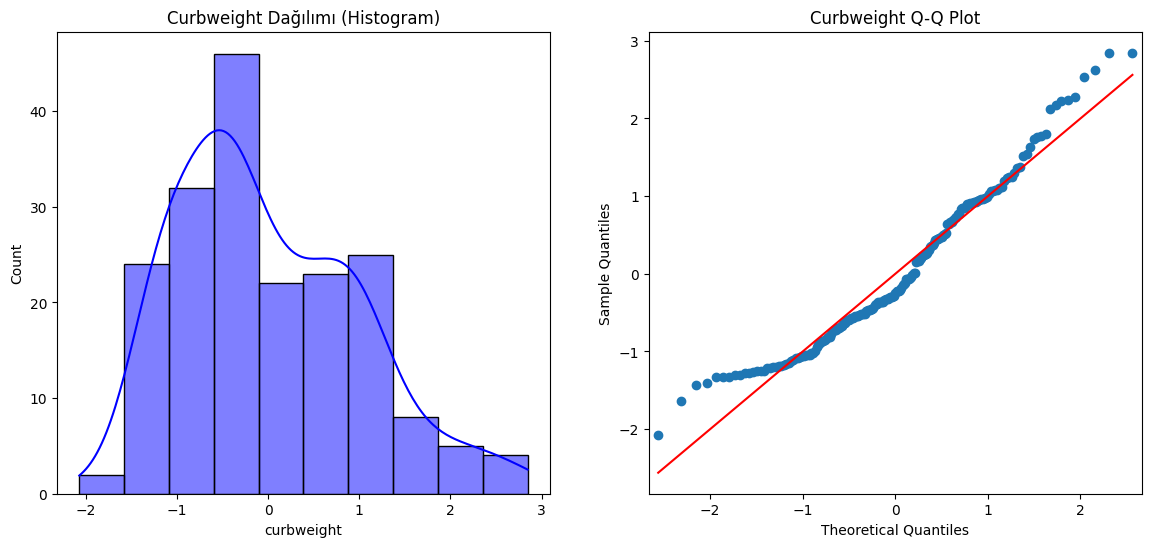

In [45]:
# 1. Hücre: Görselleştirme
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Görselleştirme alanı
plt.figure(figsize=(14, 6))

# Histogram (Dağılımın şekli)
plt.subplot(1, 2, 1)
sns.histplot(df['curbweight'], kde=True, color='blue')
plt.title('Curbweight Dağılımı (Histogram)')

# Q-Q Plot (Normallik testi)
plt.subplot(1, 2, 2)
qqplot(df['curbweight'], line='s', ax=plt.gca())
plt.title('Curbweight Q-Q Plot')

plt.show()

In [46]:
# 2. Hücre: Ölçeklendirme
from sklearn.preprocessing import StandardScaler

# Scaler nesnesini başlat
s_scaler = StandardScaler()

# curbweight sütununu seç, dönüştür ve üzerine yaz
# Not: fit_transform 2 boyutlu array beklediği için [['curbweight']] kullanıyoruz
df[['curbweight']] = s_scaler.fit_transform(df[['curbweight']])

# İşlem sonrası ilk 5 satırı kontrol edelim
print("İşlem sonrası curbweight değerleri (Scaled):")
df[['curbweight']].head()

İşlem sonrası curbweight değerleri (Scaled):


,curbweight
0,-0.048068
2,0.476395
3,-0.450474
4,0.478302
5,-0.126260


🧪 **Kodunu test et**

In [47]:
from nbresult import ChallengeResult

result = ChallengeResult('scaling',
                         dataset = df
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/S16D2-S-/S16D2-S-Data-car-prices/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2, langsmith-0.6.0
collecting ... collected 4 items

test_scaling.py::TestScaling::test_carwidth PASSED                       [ 25%]
test_scaling.py::TestScaling::test_curbweight PASSED                     [ 50%]
test_scaling.py::TestScaling::test_peakrpm PASSED                        [ 75%]
test_scaling.py::TestScaling::test_stroke PASSED                         [100%]

============================== 4 passed in 0.18s ===============================


💯 You can commit your code:

git add tests/scaling.pickle

git commit -m 'Completed scaling step'

git push origin master



## (4) Kategorik özelliklerin kodlanması (Encoding the categorical features)

❓ **Soru: Kategorik değişkenlerin encode edilmesi** ❓

👇 Encode edilmesi gereken feature’ları inceleyin ve duruma göre aşağıdaki teknikleri uygulayın:

- One-hot encoding
- Manuel ordinal encoding

DataFrame içinde, orijinal feature’ları encode edilmiş versiyonlarıyla değiştirin.

### `aspiration` & `enginelocation`

<details>
    <summary>💡 <i>İpucu</i> </summary>
    <br>
    ℹ️ <code>aspiration</code> ve <code>enginelocation</code> ikili (binary) kategorik feature’lardır.
</details>

In [48]:
from sklearn.preprocessing import OneHotEncoder

# 1. Binary (İkili) özellikleri seçelim
binary_features = ['aspiration', 'enginelocation']

# 2. Encoder'ı tanımlayalım
# drop='if_binary': İki seçenek varsa tek sütuna indirger (std=0, turbo=1 gibi)
# sparse_output=False: Sonucu normal bir array olarak verir (DataFrame içine koymak için)
ohe_binary = OneHotEncoder(drop='if_binary', sparse_output=False, dtype=int)

# 3. Dönüştür ve Orijinal Sütunların Üzerine Yaz
# fit_transform 2 sütunlu bir çıktı verecek, bunu doğrudan df içindeki 2 sütuna atayabiliriz
df[binary_features] = ohe_binary.fit_transform(df[binary_features])

# 4. Sonucu Kontrol Et
print("Dönüşüm Sonrası İlk 5 Satır:")
print(df[binary_features].head())
print("\nDeğer Sayıları:")
print(df['aspiration'].value_counts())

Dönüşüm Sonrası İlk 5 Satır:
   aspiration  enginelocation
0           0               0
2           0               0
3           0               0
4           0               0
5           0               0

Değer Sayıları:
aspiration
0    156
1     35
Name: count, dtype: int64


### `enginetype`

<details>
    <summary>💡 <i>İpucu</i> </summary>
    <br>
    ℹ️ <code>enginetype</code> çok kategorili (multicategorical) bir feature’dır ve One-hot encoding uygulanmalıdır.
</details>

In [49]:
# 1. Encoder'ı Tanımlama
# sparse_output=False: Sonucu bir Numpy array olarak almak için (DataFrame'e çevireceğiz)
# handle_unknown='ignore': Eğitimde görmediği yeni bir tür gelirse hata vermek yerine yoksayar (Robustluk için)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 2. Dönüştürme İşlemi
# enginetype sütununu alıp dönüştürüyoruz
enginetype_encoded = ohe.fit_transform(df[['enginetype']])

# 3. Yeni Sütun İsimlerini Alma
# get_feature_names_out: 'enginetype_dohc', 'enginetype_ohc' gibi isimler oluşturur
new_columns = ohe.get_feature_names_out(['enginetype'])

# 4. Kodlanmış Veriyi DataFrame'e Çevirme
# index=df.index: Satırların kaymaması için orijinal indeksleri koruyoruz
enginetype_df = pd.DataFrame(enginetype_encoded, columns=new_columns, index=df.index)

# 5. Orijinal Veri ile Birleştirme ve Eski Sütunu Silme
df = pd.concat([df, enginetype_df], axis=1)
df.drop(columns=['enginetype'], inplace=True)

# Sonucu Görelim
print("Oluşan yeni sütunlar:")
print(new_columns)
df.head()

Oluşan yeni sütunlar:
['enginetype_dohc' 'enginetype_dohcv' 'enginetype_l' 'enginetype_ohc'
 'enginetype_ohcf' 'enginetype_ohcv' 'enginetype_rotor']


,aspiration,enginelocation,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,0,0,-0.518519,-0.048068,four,-2.033333,-0.142857,expensive,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.000000,0.476395,six,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0.370370,-0.450474,four,0.366667,0.571429,expensive,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0.333333,0.478302,five,0.366667,0.571429,expensive,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0,0,0.296296,-0.126260,five,0.366667,0.571429,expensive,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
df.shape

(191, 15)

### `cylindernumber`

<details>
    <summary>💡 İpucu </summary>

ℹ️ <code>cylindernumber</code> sıralı (ordinal) bir feature’dır ve sayısal değerlere manuel olarak encode edilmelidir.

</details>

In [51]:
# 1. Mevcut benzersiz değerleri görelim (Haritayı doğru kurmak için)
print("Mevcut değerler:", df['cylindernumber'].unique())

# 2. Manuel Haritalama Sözlüğü (Mapping Dictionary)
# String ifadeleri karşılık gelen sayılara eşitliyoruz
cylinder_mapping = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

# 3. Haritalamayı Uygulama
# map fonksiyonu sözlükteki anahtarları bulup değerlerle değiştirir
df['cylindernumber'] = df['cylindernumber'].map(cylinder_mapping)

# 4. Sonucu Kontrol Etme
print("\nDönüşüm sonrası değerler ve tipleri:")
print(df['cylindernumber'].value_counts())
print("\nVeri Tipi:", df['cylindernumber'].dtype)

Mevcut değerler: ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']

Dönüşüm sonrası değerler ve tipleri:
cylindernumber
4     147
6      23
5      11
8       5
2       3
12      1
3       1
Name: count, dtype: int64

Veri Tipi: int64


❓ Artık `cylindernumber`’ı 2 ile 12 arasında sayısal bir feature’a dönüştürdüğünüze göre, bunu ölçeklendirmeniz gerekiyor ❓

<br/>

<details>
    <summary>💡 İpucu </summary>

`cylindernumber`’ın mevcut dağılımına bakın ve kendinize şu soruları sorun:
- Ölçekleme, bir feature’ın dağılımını etkiler mi?
- Bu feature’ın dağılımına göre en uygun ölçekleme yöntemi hangisidir?
</details>

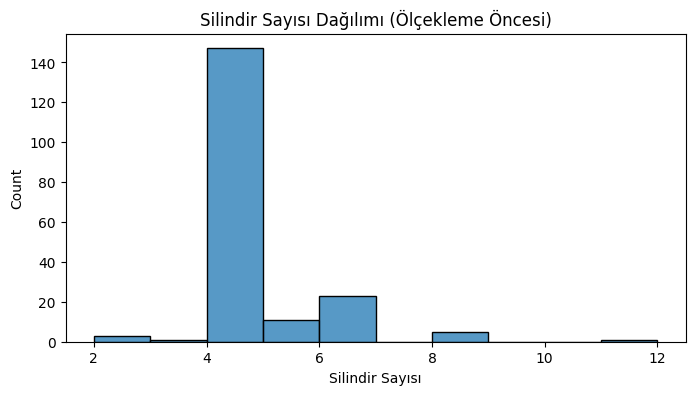

İşlem sonrası silindir değerleri (Scaled):
cylindernumber
 0.0    147
 2.0     23
 1.0     11
 4.0      5
-2.0      3
 8.0      1
-1.0      1
Name: count, dtype: int64


,aspiration,enginelocation,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,0,0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,expensive,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.000000,0.476395,2.0,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0.370370,-0.450474,0.0,0.366667,0.571429,expensive,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0.333333,0.478302,1.0,0.366667,0.571429,expensive,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0,0,0.296296,-0.126260,1.0,0.366667,0.571429,expensive,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [52]:
# 1. Dağılımı Görelim (Neden Robust seçtiğimizi kanıtlamak için)
plt.figure(figsize=(8, 4))
sns.histplot(df['cylindernumber'], kde=False, bins=10)
plt.title('Silindir Sayısı Dağılımı (Ölçekleme Öncesi)')
plt.xlabel('Silindir Sayısı')
plt.show()

# 2. Robust Scaler Uygulama
scaler_cyl = RobustScaler()

# DataFrame içine direkt atıyoruz
df[['cylindernumber']] = scaler_cyl.fit_transform(df[['cylindernumber']])

# Sonucu kontrol edelim
print("İşlem sonrası silindir değerleri (Scaled):")
print(df['cylindernumber'].value_counts())
df.head()

<details>
<summary><i>Ölçekleme ve encoding işlemlerinden sonra DataFrame’inizin nasıl görünmesi gerektiğine dair bir ekran görüntüsü aşağıdadır</i></summary>
    
    
<img src="https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/02-Prepare-the-dataset/car_price_after_scaling_and_encoding.png">    

</details>

In [55]:
print(df['price'].value_counts())

price
expensive    97
cheap        94
Name: count, dtype: int64


### `price`

👇 Hedef `price`ı kodlayın.

<details>
    <summary>💡 İpucu </summary>
    <br>
    ℹ️ <code>price</code> target değişkendir ve LabelEncoder ile encode edilmelidir.
</details>

In [56]:
from sklearn.preprocessing import LabelEncoder

# 1. Encoder'ı Başlatma
le = LabelEncoder()

# 2. Dönüştürme
# LabelEncoder alfabetik bakar: 'cheap' (c) önce gelir (0), 'expensive' (e) sonra gelir (1)
df['price'] = le.fit_transform(df['price'])

# 3. KANIT (Özellikle Belirtilen Kısım)
# Hangi kelimenin hangi sayıya dönüştüğünü açıkça görelim
mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print("Oluşan Haritalama (Mapping):")
print(mapping) 
# Beklenen Çıktı: {'cheap': 0, 'expensive': 1}

print("-" * 30)
print(f"Sütundaki Maksimum Değer: {df['price'].max()} (1 olmalı)")
print("Sınıf Dağılımı:")
print(df['price'].value_counts())

Oluşan Haritalama (Mapping):
{'cheap': 0, 'expensive': 1}
------------------------------
Sütundaki Maksimum Değer: 1 (1 olmalı)
Sınıf Dağılımı:
price
1    97
0    94
Name: count, dtype: int64


🧪 **Kodunu test et**

In [57]:
df.head()

,aspiration,enginelocation,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,0,0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.000000,0.476395,2.0,0.600000,-0.142857,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0.370370,-0.450474,0.0,0.366667,0.571429,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0.333333,0.478302,1.0,0.366667,0.571429,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0,0,0.296296,-0.126260,1.0,0.366667,0.571429,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
from nbresult import ChallengeResult

result = ChallengeResult('encoding',
                         dataset = df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/S16D2-S-/S16D2-S-Data-car-prices/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2, langsmith-0.6.0
collecting ... collected 4 items

test_encoding.py::TestEncoding::test_aspiration PASSED                   [ 25%]
test_encoding.py::TestEncoding::test_enginelocation PASSED               [ 50%]
test_encoding.py::TestEncoding::test_enginetype PASSED                   [ 75%]
test_encoding.py::TestEncoding::test_price PASSED                        [100%]

============================== 4 passed in 0.17s ===============================


💯 You can commit your code:

git add tests/encoding.pickle

git commit -m 'Completed encoding step'

git push origin master



## (5) Temel Modelleme (Base Modelling)

👏 Veri kümesi ön işleme tabi tutuldu ve artık modele uyarlanmaya hazır. 

❓ **Soru: Bir classification modelini ilk kez değerlendirme** ❓

Ön işlenmiş bu dataset üzerinde bir `LogisticRegression` modeli için cross-validation çalıştırın ve elde edilen skoru `base_model_score` adlı değişkende saklayın.

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 1. Özellikler (X) ve Hedef (y) ayrımı
# 'price' hedefimiz olduğu için onu y'ye alıyoruz, geri kalanı X oluyor.
X = df.drop(columns=['price'])
y = df['price']

# 2. Modeli Başlatma
# max_iter=1000 parametresi, modelin yakınsaması (converge) için yeterli döngü sağlar.
model = LogisticRegression(max_iter=1000)

# 3. Cross-Validation (Çapraz Doğrulama)
# cv=5: Veriyi 5 parçaya böler, 4'üyle eğitip 1'iyle test eder. Bunu 5 kez tekrarlar.
scores = cross_val_score(model, X, y, cv=5)

# 4. Skoru Hesaplama (Ortalama Başarı)
base_model_score = scores.mean()

print(f"Base Model Score (Accuracy): {base_model_score:.4f}")

Base Model Score (Accuracy): 0.8430


🧪 **Kodunu test et**

In [60]:
from nbresult import ChallengeResult

result = ChallengeResult('base_model',
                         score = base_model_score
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/S16D2-S-/S16D2-S-Data-car-prices/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2, langsmith-0.6.0
collecting ... collected 1 item

test_base_model.py::TestBase_model::test_base_model_score PASSED         [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/base_model.pickle

git commit -m 'Completed base_model step'

git push origin master



## (6) Özellik Seçimi  (Feature Selection (with _Permutation Importance_))

👩🏻‍🏫 Bir feature’ın target’ı tahmin etmede gerçekten önemli olup olmadığını tespit etmenin güçlü bir yolu şudur:

1. Bir model çalıştırın ve skorunu ölçün  
2. Bu feature’ı karıştırın (shuffle edin), modeli tekrar çalıştırın ve skoru tekrar ölçün  
    - Eğer performans **belirgin şekilde düşerse**, bu feature önemlidir ve **çıkarılmamalıdır**
    - Eğer performans **çok fazla düşmezse**, bu feature **elenebilir**

❓ **Sorular** ❓

1. Modele en az bilgi katkısı sağlayan feature’ları tespit etmek için feature permutation uygulayın.
2. Model performansının belirgin şekilde düşmeye başladığını fark edene kadar zayıf feature’ları dataset’ten çıkarın.
3. Elde ettiğiniz yeni güçlü feature set’i ile yeni bir modeli cross-validation ile değerlendirin ve skorunu `strong_model_score` adlı değişkende saklayın.

In [104]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# 1. Modeli Tanımla
# max_iter değerini 5000 yaptık. Bu, modelin "failed to converge" uyarısını çözecektir.
model = LogisticRegression(max_iter=5000, random_state=1)

# Modeli tüm veriye fit et
model.fit(X, y)

# 2. Permutation Importance
# 30 tekrar ile sağlam bir ölçüm
permutation_score = permutation_importance(model, X, y, n_repeats=30, random_state=1)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': permutation_score.importances_mean
}).sort_values(by='importance', ascending=False)

# 3. Özellik Seçimi
# Threshold 0.002 gayet iyi çalışmış görünüyor.
threshold = 0.002
strong_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

print(f"Toplam Özellik Sayısı: {len(X.columns)}")
print(f"Seçilen Güçlü Özellik Sayısı: {len(strong_features)}")
print(f"Elenen Özellikler: {list(set(X.columns) - set(strong_features))}")

# 4. Final Değerlendirme
X_strong = X[strong_features]
scores_strong = cross_val_score(model, X_strong, y, cv=5)
strong_model_score = scores_strong.mean()

print("-" * 30)
print(f"Hedef Skor       : > 0.8600")
print(f"Strong Model Score : {strong_model_score:.4f} 🚀")

Toplam Özellik Sayısı: 30
Seçilen Güçlü Özellik Sayısı: 8
Elenen Özellikler: ['smoothness error', 'worst concavity', 'mean texture', 'perimeter error', 'mean smoothness', 'concavity error', 'mean concave points', 'mean fractal dimension', 'worst radius', 'compactness error', 'worst symmetry', 'mean compactness', 'concave points error', 'worst concave points', 'fractal dimension error', 'radius error', 'symmetry error', 'worst compactness', 'mean symmetry', 'worst smoothness', 'mean concavity', 'worst fractal dimension']
------------------------------
Hedef Skor       : > 0.8600
Strong Model Score : 0.9490 🚀


🧪 **Kodunu test et**

In [105]:
from nbresult import ChallengeResult

result = ChallengeResult('strong_model',
                         score = strong_model_score
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/egkpnr/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /home/egkpnr/code/EGkpnr/S16D2-S-/S16D2-S-Data-car-prices/tests
plugins: anyio-4.8.0, dash-3.3.0, typeguard-4.4.2, langsmith-0.6.0
collecting ... collected 1 item

test_strong_model.py::TestStrong_model::test_strong_model_score PASSED   [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/strong_model.pickle

git commit -m 'Completed strong_model step'

git push origin master



## Bonus -  Verilerinizi sınıflandırma (Stratifying your data) ⚖️

💡 Veriyi training ve testing olarak bölerken, dataset’imizdeki kategorik değişkenlerin oranına dikkat etmemiz gerekir — ister target `y`’nin sınıfları olsun ister `X` içindeki kategorik bir feature olsun.

Aşağıda bir örneğe bakalım 👇

❓ Orijinal `X` ve `y` verinizi sklearn’in `train_test_split` fonksiyonunu kullanarak training ve testing olarak ayırın; karşılaştırılabilir sonuçlar elde etmek için `random_state=1` ve `test_size=0.3` kullanın.

In [ ]:
# SENİN KODUN BURAYA

❓ Training dataset’inizde ve testing dataset’inizde `price` sınıfı **1** olan araçların oranını kontrol edin.

> _Ham `df` içinde bu orana baktığınızda, yaklaşık **%50 / %50** olması gerekir._

In [ ]:
# SENİN KODUN BURAYA

☝️ Hâlâ yaklaşık olarak **%50 / %50** civarında olmalı.

***Peki random state’i değiştirirsek ne olur?***

❓ `random_state` değerlerini **1’den 10’a** kadar döngüye alın ve her seferinde training ve testing dataset’lerindeki `price` sınıfı **1** olan araçların oranını hesaplayın. ❓

In [ ]:
# SENİN KODUN BURAYA

Her seferinde oranların değiştiğini, hatta bazen oldukça ciddi şekilde değiştiğini gözlemleyeceksiniz 😱! Bu durum model performansını etkileyebilir.

❓ `train_test_split(random_state=1)` kullanılarak eğitilen bir Logistic Regression modelinin test skorunu,  
`random_state=9` kullanılarak eğitilen modelin test skoru ile karşılaştırın ❓

Eğitimi training data üzerinde yapmayı ve skoru testing data üzerinde hesaplamayı unutmayın.

In [ ]:
# SENİN KODUN BURAYA

👀 `random_state=9` ile çok daha düşük bir skor görmelisiniz; çünkü bu test setindeki sınıf **1** araçların oranı %34.5 iken, training setinde bu oran %57.9’a, hatta orijinal dataset’te yaklaşık %50’ye yakındır.

Bu durum oldukça önemlidir; çünkü dataset’te oluşan bu **rastlantısal dengesizlik**, yalnızca model performansını düşürmekle kalmaz, aynı zamanda eğitim veya değerlendirme sırasında “gerçekliği” de bozabilir 🧐

***Peki bu sorunu nasıl çözebiliriz? Tren seti ve test seti arasında sınıfların dağılımını nasıl aynı tutabiliriz? 🔧***

🎁 Neyse ki sklearn’de, estimator (yani model) bir classifier olduğunda ve target bir sınıf olduğunda, bu durum `cross_validate` tarafından otomatik olarak ele alınır. 📚 [**sklearn.model_selection.cross_validate**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) dokümantasyonunda `cv` parametresini inceleyin.

Çözüm, aşağıdakini kullanmaktır:

> 📚 [**Stratification (Katmanlama)**](https://scikit-learn.org/stable/modules/cross_validation.html#stratification)

### Hedefin tabakalaşması (Stratification of the target)

💡 ***Stratification*** tekniğini `train_test_split` içinde de kullanabiliriz.

❓ Bu kez **1’den 10’a** kadar olan `random_state` döngüsünü tekrar çalıştırın, ancak bu sefer holdout yöntemine ***`stratify=y`*** parametresini de ekleyin. ❓

In [ ]:
# SENİN KODUN BURAYA

👀 Random state değişse bile, training ve testing verilerindeki sınıf oranları, orijinal `y` içindeki oranlarla aynı tutulur. İşte _stratification_ (katmanlama) tam olarak budur.

`train_test_split` fonksiyonunu `stratify` parametresiyle kullandığımızda, training ve testing verileri arasında **bir feature’ın oranlarını da koruyabiliriz**. Bu, özellikle aşağıdaki durumlarda son derece önemlidir:

- Churn tahmininde erkek ve kadın müşteri oranlarını korumak 🙋‍♂️ 🙋
- Ev fiyatlarını tahmin ederken büyük ve küçük evlerin oranlarını korumak 🏠 🏰
- Bir sonraki ürünü önerirken 1–5 arası review score dağılımını (multiclass!) korumak 🛍️
- vb.

Örneğin, bizim dataset’imizde `aspiration` feature’ının training ve testing verilerinde aynı oranda kalmasını istiyorsak, şu şekilde yazabiliriz:

`train_test_split(X, y, test_size=0.3, stratify=X.aspiration)`

---

Gördüğümüz gibi, **`cross_validate` [target değişkeni otomatik olarak stratify edebilir](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#:~:text=For%20int/None%20inputs%2C%20if%20the%20estimator%20is%20a%20classifier%20and%20y%20is%20either%20binary%20or%20multiclass%2C%20StratifiedKFold%20is%20used.)**, ancak **feature’lar için bunu yapmaz** 🤔 Bunun için biraz ekstra çalışmaya ihtiyacımız var.

Bunun için `StratifiedKFold` kullanmamız gerekiyor 🔬

### Tabakalaşma (Stratification - generalized)

📚 [**StratifiedKFold**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), veriyi `K` parçaya bölerken belirli sütunlar (feature veya target) üzerinden stratification yapmamıza olanak tanır.

Bu sayede, ilgilendiğimiz kategorik feature’ların oranlarını koruyarak manuel bir cross-validation yapabiliriz — bunu ikili (binary) `aspiration` feature’ı ile deneyelim:

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Veriyi 5 fold’a bölecek bir stratified k-fold oluşturma
skf = StratifiedKFold(n_splits=5)
scores = []

# .split() metodu bir iterator oluşturur; 'X.aspiration' stratify edeceğimiz feature’dır
for train_indices, test_indices in skf.split(X, X.aspiration):

    # 'train_indices' ve 'test_indices', orantılı bölünmeler üreten indeks listeleridir
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # modeli başlatma ve eğitme
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # en sonunda 5 fold’un ortalamasını almak için skoru listeye ekleme
    scores.append(model.score(X_test, y_test))

np.array(scores).mean()

📚 [**StratifiedKFold**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), veriyi `K` parçaya bölerken belirli sütunlar (feature veya target) üzerinden stratification yapmamıza olanak tanır.

Bu sayede, ilgilendiğimiz kategorik feature’ların oranlarını koruyarak manuel bir cross-validation yapabiliriz — bunu ikili (binary) `aspiration` feature’ı ile deneyelim:


🏁 Tebrikler! Tüm veri setini hazırladınız, özellik seçimi yaptınız ve hatta tabakalaşma hakkında bilgi edindiniz 💪.

💾 Not defterinizi git add/commit/push yapmayı unutmayın...

🚀 ... ve bir sonraki challenge'a geçin!